TODO list:

- build 3 corner reflectors
- make 3 long wires for servos
- mount 3 servos + reflectors
- command all 3 simulaneously

In [1]:
from __future__ import division

import serial
import numpy as np
import scipy.signal as signal
from collections import defaultdict
import Queue
import time
import threading
import matplotlib.pyplot as plt
%matplotlib inline

from rtlsdr import RtlSdr, librtlsdr, helpers

In [2]:
from utils import *

In [3]:
class Servos:
    """
    Commands servos via serial port
    """
    
    def __init__(self, num_servos, port, baudrate=115200):
        self.num_servos = num_servos
        self.lock_serial = threading.RLock()
        self.serial = serial.Serial(port, baudrate=baudrate, timeout=1.)
        
        self.min_angle = -np.pi/4.
        self.max_angle = np.pi/4.
        
        self.read_queues = [Queue.Queue() for _ in xrange(self.num_servos)]
        self.read_stop = False
        self.read_serial_thread = threading.Thread(target=self.read_serial_run, args=())
        self.read_serial_thread.daemon = True
        self.read_serial_thread.start()
    
    def set_angle(self, ith, angle, speed, block=True):
        s = '{0} {1:.3f} {2:.3f}\n'.format(ith, angle, speed)
        with self.lock_serial:
            for char in s:
                self.serial.write(char)
                time.sleep(0.001)
            
        if block:
            q = self.read_queues[ith]
            with q.mutex:
                q.queue.clear()
            return self.get_angle_and_time(ith)
        
    def read_serial_run(self):
        while not self.read_stop:
            #print('read_serial_run: waiting for readline...')
            #line = self.read_line()
            try:
                line = self.serial.readline()
            except Exception:
                time.sleep(0.001)
                continue
            if len(line) == 0:
                continue
            servo_num, angle, t = line.split('_')

            servo_num = int(servo_num)
            angle = float(angle)
            t = float(t)

            #print('servo_num: {0}'.format(servo_num))
            #print('angle: {0}'.format(angle))
            #print('t: {0}\n'.format(t))
            self.read_queues[servo_num].put((angle, t))
            
    def get_angle_and_time(self, ith):
        return self.read_queues[ith].get()
    
if 'servos' in locals():
    servos.read_stop = True
    time.sleep(0.1)
servos = Servos(3, '/dev/ttyACM0')

In [10]:
#####################
# Test ServosSerial #
#####################

speed = np.pi/4
ith = 2

t0 = time.time()
a0, _ = servos.set_angle(ith, servos.min_angle, speed)
a1, _ = servos.set_angle(ith, servos.max_angle, speed)
a2, _ = servos.set_angle(ith, 0, speed)
t1 = time.time()

print('[a0, a1]: [{0}, {1}]'.format(a0, a1))
print('Elapsed: {0}'.format(t1 - t0))

[a0, a1]: [-0.769, 0.769]
Elapsed: 4.02107095718


In [4]:
class SDRs:
    """
    Functionality for multiple SDRs (non-blocking)
    """
    def __init__(self, rtlsdr_devs, fc, fs=2.4e5, gain=1.0):
        self.rtlsdr_devs = rtlsdr_devs
        self.rtlsdrs = [None]*len(self.rtlsdr_devs)
        
        self.fc = fc
        self.fs = fs
        self.gain = gain
            
        # for asynchronous reads
        self.read_queues = [Queue.Queue() for _ in self.rtlsdr_devs]
        self.read_run_flags = [False]*len(self.rtlsdr_devs)
        self.read_is_stoppeds = [False]*len(self.rtlsdr_devs)
        self.read_threads = [None]*len(self.rtlsdr_devs)
        
        for ith, rtlsdr_dev in enumerate(self.rtlsdr_devs):
            if rtlsdr_dev is None:
                continue
            
            self.rtlsdrs[ith] = RtlSdr(rtlsdr_dev)
            self.rtlsdrs[ith].sample_rate = self.fs
            self.rtlsdrs[ith].center_freq = self.fc
            self.rtlsdrs[ith].gain = self.gain

            self.read_threads[ith] = threading.Thread(target=self.run, args=(ith,))
            self.read_threads[ith].daemon = True
            self.read_threads[ith].start()
            
    def set_gains(self, gain):
        self.gain = gain
        for rtlsdr in self.rtlsdrs:
            if rtlsdr is not None:
                rtlsdr.gain = self.gain
    
    def start_read(self, ith):
        if self.read_run_flags[ith] or \
            self.rtlsdr_devs[ith] is None or \
            self.read_is_stoppeds[ith]:
            return False
        
        self.read_run_flags[ith] = True
        return True
        
    def stop_read(self, ith):
        """ Returns maxPower of samples gathered """
        if not self.read_run_flags[ith] or self.rtlsdr_devs[ith] is None:
            return None
        
        self.read_run_flags[ith] = False
        
        x = np.array([])
        while not self.read_queues[ith].empty():
            x = np.append(x, self.read_queues[ith].get())
        return np.array(x)
    
    def run(self, ith, M=32*1024): # 64 * 1024
        def read_cb(samples, q):
            if self.read_run_flags[ith]:
                try:
                    #q.put(maxPower(samples, N=4*1024))
                    #q.put(maxPower(samples - samples.mean(), N=4*1024))
                    #q.put((samples - samples.mean()))
                    q.put(samples)
                except Exception as e:
                    print('read_cb exception: {0}'.format(e))
            
        try:
            self.rtlsdrs[ith].read_samples_async(read_cb, M, context=self.read_queues[ith])
        except Exception as e:
            print(e)
        self.read_is_stoppeds[ith] = True
    
num_sdrs = 3
fc = 910e6

dev_cnt = librtlsdr.rtlsdr_get_device_count()
print('Devices found: {0}'.format(dev_cnt))
rtlsdr_devs = [i if i < dev_cnt else None for i in xrange(num_sdrs)]
sdrs = SDRs(rtlsdr_devs, fc)

Devices found: 2


In [5]:
#############
# Test SDRs #
#############
ith = 0

print('Start reading')
sdrs.start_read(ith)
print('Sleeping...')
time.sleep(1)
print('Stop reading')
x = np.array([])
start = time.time()
x = sdrs.stop_read(ith)
print('len(x): {0}'.format(len(x)))
print('time to stop: {0}'.format(time.time() - start))

Start reading
Sleeping...
Stop reading
len(x): 64
time to stop: 0.000324964523315


In [5]:
class ServosSDRs:
    """
    Command servos and read from SDRs
    """
    def __init__(self, servos, sdrs):
        self.servos = servos
        self.sdrs = sdrs
        
        self.default_speed = np.pi/3.
        
        self.run_flags = [False]*self.servos.num_servos
        self.is_stoppeds = [False]*self.servos.num_servos
        self.threads = [None]*self.servos.num_servos
        
        self.angles_and_maxpowers = [Queue.Queue() for _ in xrange(self.servos.num_servos)]
        
    def start(self, ith, speed=None, run_on_stop_read=lambda:None):
        if self.run_flags[ith]:
            return
        
        q = self.angles_and_maxpowers[ith]
        with q.mutex:
            q.queue.clear()
        
        self.run_flags[ith] = True
        self.threads[ith] = threading.Thread(target=self.run, args=(ith,speed,run_on_stop_read,))
        self.threads[ith].daemon = True
        self.threads[ith].start()                 
    
    def stop(self, ith):
        if not self.run_flags[ith]:
            return
        
        self.run_flags[ith] = False
        
        while not self.is_stoppeds[ith]:
            time.sleep(0.2)
        self.is_stoppeds[ith] = False
        
    def run(self, ith, speed=None, run_on_stop_read=lambda:None):
        """ run_on_stop_read for things like plotting """
        print('ServosSdrs: run {0}th'.format(ith))
        speed = self.default_speed if speed is None else speed
        num_exceptions = 0
        
        curr_angle = self.servos.min_angle
        self.servos.set_angle(ith, curr_angle, speed)
        des_angle = self.servos.max_angle
        
        while self.run_flags[ith]:
            try:
                self.sdrs.start_read(ith)
                angle, t = self.servos.set_angle(ith, des_angle, speed)
                mp = self.sdrs.stop_read(ith)
                
                if mp is not None:
                    angles = np.linspace(curr_angle, des_angle, len(mp))
                    self.angles_and_maxpowers[ith].put([angles, mp])
                
                curr_angle, des_angle = des_angle, curr_angle
                run_on_stop_read()
            except Exception as e:
                num_exceptions += 1
                print('ServosSdr.run exception: {0}'.format(e))
        
                if num_exceptions > 1:
                    break
        
        self.is_stoppeds[ith] = True
        self.servos.set_angle(ith, 0, speed, block=False)
        
        print('ServosSdrs: stopping {0}th'.format(ith))
        
    def get_angles_and_maxpowers(self, ith):
        """ For ith sdr, return oldest angle/sample if exists, else None """
        if not self.angles_and_maxpowers[ith].empty():
            return self.angles_and_maxpowers[ith].get()
            
servos_sdrs = ServosSDRs(servos, sdrs)

In [27]:
###################
# Test ServosSDRs #
###################

sdrs.set_gains(1e6)

"""
ham = serial.Serial('/dev/ttyUSB0')
ham.setDTR(0)

try:
    p.terminate()
except:
    pass
p = pyaudio.PyAudio()
Qout = play_pure_tone_continuously(p, ham, 2000., mag=0.5)
"""

antennas = [0,1]
for ith in antennas:
    servos_sdrs.start(ith, speed=np.pi/5.)

print('Press enter to stop')
raw_input()

for ith in antennas:
    servos_sdrs.stop(ith)

"""
ham.setDTR(0)
Qout.put("KEYOFF")
Qout.put("EOT")
p.terminate()
"""

angles_and_maxpowers = list()
for ith in antennas:
    print('Computing for {0}th'.format(ith))
    a_mp_list = list()
    a_mp = servos_sdrs.get_angles_and_maxpowers(ith)
    while a_mp is not None:
        print('Reading a,mp')
        a_mp_list.append(a_mp)
        a_mp = servos_sdrs.get_angles_and_maxpowers(ith)
    print('{0}th rotations: {1}'.format(ith, len(a_mp_list)))
    angles_and_maxpowers.append(a_mp_list)

ServosSdrs: run 0th
ServosSdrs: run 1th
Press enter to stop

ServosSdrs: stopping 0th
ServosSdrs: stopping 1th
Computing for 0th
Reading a,mp
Reading a,mp
0th rotations: 2
Computing for 1th
Reading a,mp
Reading a,mp
Reading a,mp
1th rotations: 3


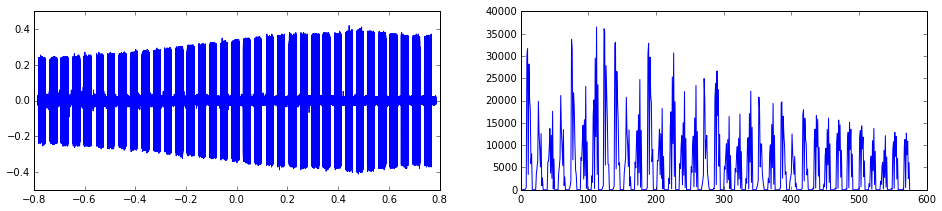

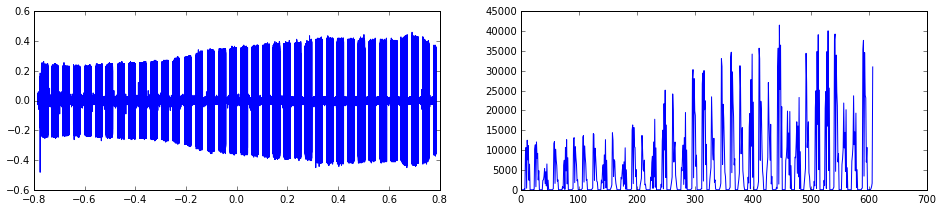

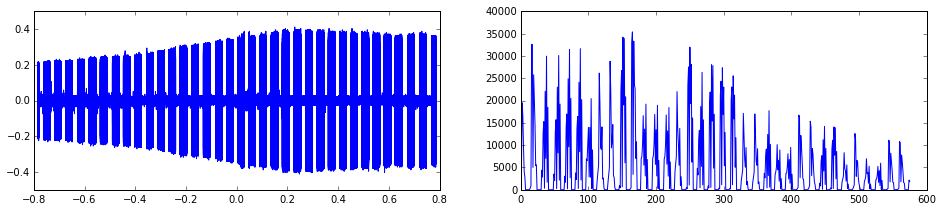

In [28]:
for a_mp_list in angles_and_maxpowers[1:]:
    for angles, mp in a_mp_list:
        mp_smooth = smoothMaxPower(mp, 100)
        #angles = np.linspace(angles[0], angles[-1], len(mp))
        angles = angles[::-1]

        width, height = plt.figaspect(0.2)
        f, axes = plt.subplots(1,2, figsize=(width,height))
        axes[0].plot(angles, np.real(mp))
        
        F = np.fft.fft(abs(mp))
        freq = (sdrs.fs/2.) * np.fft.fftfreq(F.shape[-1])
        b = abs(freq) < 1e6 # (abs(freq) < 5000) * (abs(freq) > 100)
        #axes[1].plot(freq[b], abs(F)[b], 'x')
        
        axes[1].plot(maxPower(mp, 1*1024))
        
        #axes[0].plot(angles, mp)
        #axes[0].plot(angles, mp_smooth, 'r--', linewidth=2.0)
        #axes[1].plot(angles, 1 - mp/mp.sum())
        #axes[1].plot(angles, mp_smooth/mp_smooth.sum(), 'r--', linewidth=2.0)
        #plt.ylim((mp.mean()-3*mp.std(), mp.mean()+3*mp.std()))

In [78]:
#####################################
# Test shielding makes a difference #
#####################################
"""
ham = serial.Serial('/dev/ttyUSB0')
ham.setDTR(0)

p = pyaudio.PyAudio()
duration = 6.0
#play_pure_tone(p, ham, 3000., duration, mag=5.0)
Qout = play_pure_tone_continuously(p, ham, 3000., mag=0.1)
"""

duration = 4.0
time.sleep(0.2)
sdrs.set_gains(1e6)
sdrs.start_read(1)
time.sleep(duration-0.2)
data = sdrs.stop_read(1)

"""
ham.setDTR(0)
Qout.put("KEYOFF")
Qout.put("EOT")
p.terminate()
"""

'\nham.setDTR(0)\nQout.put("KEYOFF")\nQout.put("EOT")\np.terminate()\n'

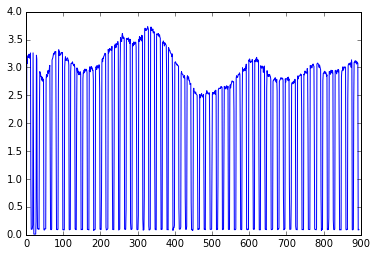

In [79]:
#f = plt.figure()
#plt.plot(np.real(data))

f = plt.figure()
mp = avgPower(data, 1*1024)
plt.plot(mp)

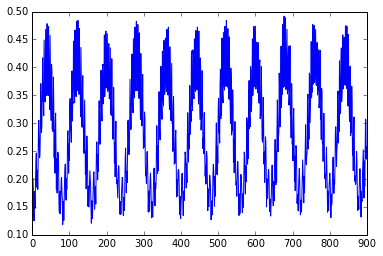

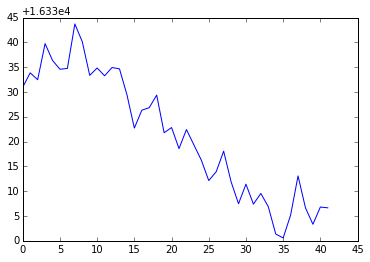

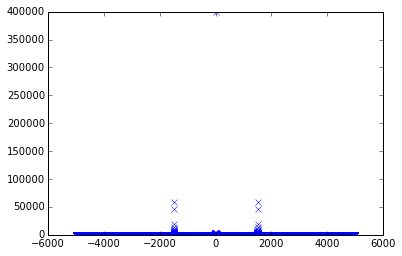

In [7]:
# raw, no demodulating, avgpower
fd_prod = data * np.conj(np.roll(data, -1))
phase = np.angle(fd_prod)
f = plt.figure()
plt.plot(phase[100:1000])

f = plt.figure()
mp = avgPower(data, 32*1024)
good = abs(mp - mp.mean()) < 3*mp.std()
plt.plot(mp[good])

f = plt.figure()
D = np.fft.fft(phase)
freq = (sdrs.fs/2.) * np.fft.fftfreq(D.shape[-1])
b = (freq > -5000) * (freq < 5000) # (abs(freq) < 5000) * (abs(freq) > 100)
plt.plot(freq[b], abs(D)[b], 'x')

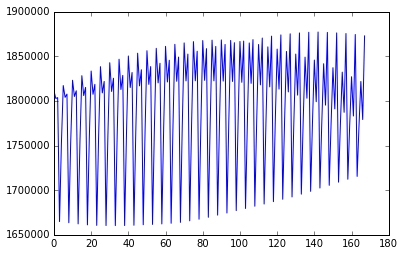

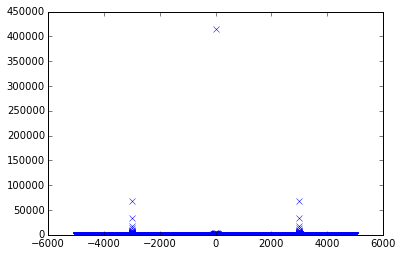

In [59]:
#dec = 100
#data_dec = data[::dec]
#fs = sdrs.fs / dec

fs = sdrs.fs
LP = signal.firwin(100, 500/dec, nyq=fs/2.)
t = np.r_[0:100]/fs
#BP = np.exp(-1j*2*np.pi*3000./dec*t) * LP
#data_smooth = signal.fftconvolve(data, BP)

fd_prod = data * np.conj(np.roll(data, -1))
phase = np.angle(fd_prod)
mp = maxPower(phase, 8*1024)
good = abs(mp - mp.mean()) < 3*mp.std()
plt.plot(mp[good])



f = plt.figure()
D = np.fft.fft(phase)
freq = (sdrs.fs) * np.fft.fftfreq(D.shape[-1])
b = (freq > -5000) * (freq < 5000) # (abs(freq) < 5000) * (abs(freq) > 100)
plt.plot(freq[b], abs(D)[b], 'x')

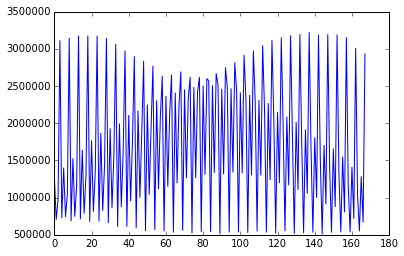

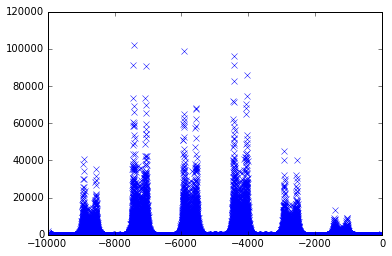

In [47]:
# raw, no demodulating
mp = maxPower(data, 8*1024)
good = abs(mp - mp.mean()) < 3*mp.std()
plt.plot(mp[good])



f = plt.figure()
D = np.fft.fft(data)
freq = (sdrs.fs/2.) * np.fft.fftfreq(D.shape[-1])
b = (freq > -10000) * (freq < 0) # (abs(freq) < 5000) * (abs(freq) > 100)
plt.plot(freq[b], abs(D)[b], 'x')

(1376256,)


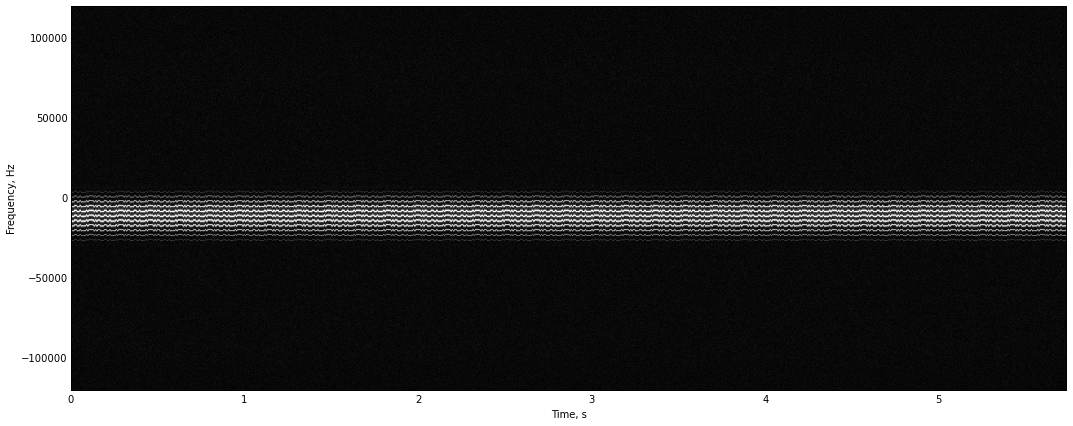

In [48]:
print data.shape
_ = myspectrogram_hann_ovlp(data, 1024, sdrs.fs, 0)

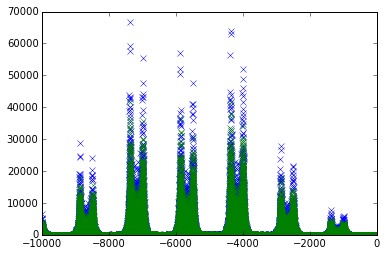

In [19]:
#data_covered = data
f = plt.figure()

D = np.fft.fft(data_covered)
freq = (sdrs.fs/2.) * np.fft.fftfreq(D.shape[-1])
b = (freq > -10000) * (freq < 0) # (abs(freq) < 5000) * (abs(freq) > 100)
plt.plot(freq[b], abs(D)[b], 'x')

D = np.fft.fft(data_omni)
freq = (sdrs.fs/2.) * np.fft.fftfreq(D.shape[-1])
b = (freq > -10000) * (freq < 0) # (abs(freq) < 5000) * (abs(freq) > 100)
plt.plot(freq[b], abs(D)[b], 'x')


In [3]:
ham = serial.Serial('/dev/ttyUSB0')
ham.setDTR(0)

p = pyaudio.PyAudio()
Qout = play_pure_tone_continuously(p, ham, 3000., mag=1)

print('Press enter to stop')
raw_input()

ham.setDTR(0)
Qout.put("KEYOFF")
Qout.put("EOT")
p.terminate()

Press enter to stop

Exception
